# DNN Model for One Particle in Harmonic Oscillator

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from system import *

In [2]:
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx("float64")

%load_ext autoreload
%autoreload 2

In [3]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [4]:
class Ansatz(tf.keras.Model):
    def __init__(self, nodes, activation = "tanh"):
        super().__init__()
        self.activation = activation
        
        self.Layers = []
        for node in nodes:
            self.Layers.append(tf.keras.layers.Dense(node))
    
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        for layer in self.Layers:
            if self.activation == "tanh":
                x = tf.math.tanh(layer(x))
            
            if self.activation == "relu":
                x = tf.nn.relu(layer(x))
                
        return tf.math.exp(self.out(x))   
    
  
@tf.function
def loss(system, x):
    batch_size = x.shape[1]
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]
    _x2 = tf.transpose(tf.stack(_x_))[0]


    psi = system.Ansatz(_x2)
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(batch_size):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
    
    K_L = -0.5*d2_psi/psi
    
    E_L = K_L + system.External(x) 
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    loss_value = 2*(tf.math.reduce_mean(tf.math.log(psi)*E_L) - tf.math.reduce_mean(tf.math.log(psi))*E)
    
    return E, loss_value, E_L, K_L


@tf.function
def grad(system, x):
    with tf.GradientTape() as tape:
        E, loss_value, _, _  = loss(system, x)

    return E, tape.gradient(loss_value, system.Ansatz.trainable_variables)


def train(system, num_epochs, batch_size, optimizer, verbose = True):
    energy = []
    
    for epoch in tqdm(range(num_epochs)):
        x = system.Sampler(batch_size)[0]

        E, gradients = grad(system, x)
        energy.append(E)

        optimizer.apply_gradients(zip(gradients, system.Ansatz.trainable_variables))
        
        if verbose:
            if epoch%100 == 0: 
                print(f"epoch: {epoch}, Energy: {E}")
    
    return energy


def observables(system, batch_size, x = None):
    if (x == None):
        x = system.Sampler(batch_size)
    
    _, _, E_L, K_L = loss(system, x)
    E = tf.math.reduce_mean(E_L).numpy()
    E2 = tf.math.reduce_mean(E_L**2).numpy()
    Var = E2 - E**2
    return E, Var, K_L

## 1D

### Smooth activation function (tanh)

#### Model paramters

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes)
external = HarmonicOsc(1)
sampler = Metropolis(1.5, 20)

system = System(num_part = 1,
                 dim = 1,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)

#### Training

In [6]:
num_epochs = 500
batch_size = 500

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 10.015391488926234
epoch: 100, Energy: 0.5301368885011893
epoch: 200, Energy: 0.5028966965491962
epoch: 300, Energy: 0.5034162019582591
epoch: 400, Energy: 0.4980848812136077



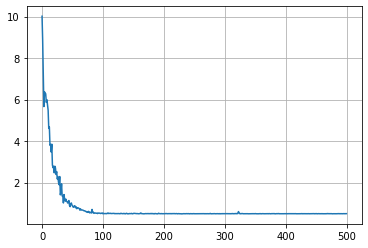

In [7]:
plt.plot(energy)
plt.grid()
plt.show()

In [8]:
N = 100000
_, accepted = system.Sampler(N)
print(f"{accepted}/{20*N}")

1226591/2000000


In [9]:
x = tf.convert_to_tensor(np.linspace(-5, 5, 1000).reshape(-1,1), dtype=tf.dtypes.float64)
dx = x[1] - x[0]

psi = system.Ansatz(x).numpy()
psi *= np.sqrt(1/(dx*np.sum(psi**2)))
psi_analytical = np.pi**(-0.25)*np.exp(-0.5*x**2)

_, _, _, K_L = loss(system, x)
K_L_analytical = 0.5 - 0.5*x**2 

#### Numerical vs Analytical Wave Function

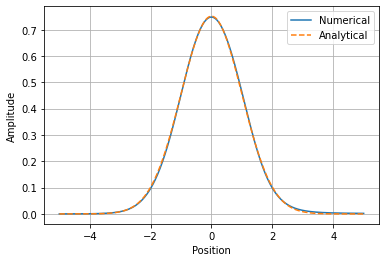

In [10]:
plt.plot(x, psi)
plt.plot(x, psi_analytical, "--")
plt.legend(["Numerical", "Analytical"])
plt.xlabel("Position")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

#### Local Kinetic Energy Using Tanh as Activation

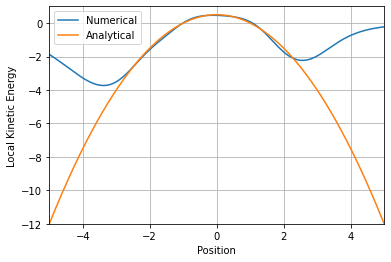

In [11]:
plt.plot(x, K_L)
plt.plot(x, K_L_analytical)
plt.xlabel("Position")
plt.ylabel("Local Kinetic Energy")
plt.legend(["Numerical", "Analytical"])
plt.ylim([-12,1])
plt.xlim([-5,5])
plt.grid()
plt.show()

#### Ground state energy

In [12]:
N = 1000000
x, _ = system.Sampler(N)
E, Var, _ = observables(system, N, x)
print("Energy: ", E)
print("Std: ", np.sqrt(Var))

Energy:  0.5008406764218502
Std:  0.08985267123789005


# Testing Relu activation

#### Model Parameters

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes, activation = "relu")
external = HarmonicOsc(1)
sampler = Metropolis(1.5, 20)

system = System(num_part = 1,
                 dim = 1,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)

#### Training

In [14]:
num_epochs = 500
batch_size = 500

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 9.000935735083672
epoch: 100, Energy: -0.0010721136989656362
epoch: 200, Energy: 0.09629257681564696
epoch: 300, Energy: -0.05919187280405365
epoch: 400, Energy: -0.08523012071963558



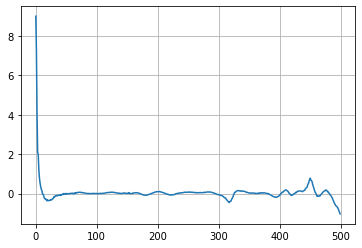

In [15]:
plt.plot(energy)
plt.grid()
plt.show()

In [16]:
x = tf.convert_to_tensor(np.linspace(-5, 5, 1000).reshape(-1,1), dtype=tf.dtypes.float64)
dx = x[1] - x[0]

psi = system.Ansatz(x).numpy()
psi *= np.sqrt(1/(dx*np.sum(psi**2)))
psi_analytical = np.pi**(-0.25)*np.exp(-0.5*x**2)

_, _, _, K_L = loss(system, x)
K_L_analytical = 0.5 - 0.5*x**2 

#### Numerical vs Analytical Wave Function

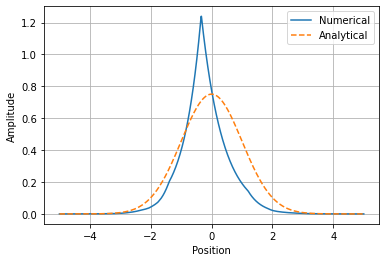

In [17]:
plt.plot(x, psi)
plt.plot(x, psi_analytical, "--")
plt.legend(["Numerical", "Analytical"])
plt.xlabel("Position")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

#### Local Kinetic Energy Using Tanh as Activation

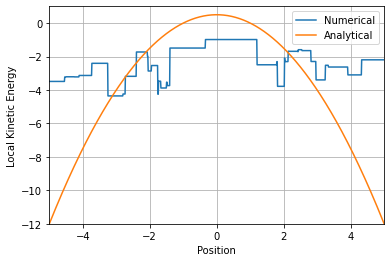

In [18]:
plt.plot(x, K_L)
plt.plot(x, K_L_analytical)
plt.xlabel("Position")
plt.ylabel("Local Kinetic Energy")
plt.legend(["Numerical", "Analytical"])
plt.ylim([-12,1])
plt.xlim([-5,5])
plt.grid()
plt.show()

#### Ground State Energy

In [19]:
N = 1000000
x, _ = system.Sampler(N)
E, Var, _ = observables(system, N, x)
print("Energy: ", E)
print("Std: ", np.sqrt(Var))

Energy:  -1.101748789131226
Std:  0.25347498816703684


## 2D

#### Model Parameters

In [74]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes)
external = HarmonicOsc(1)
sampler = Metropolis(1, 20)

system = System(num_part = 1,
                 dim = 2,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)

#### Training

In [75]:
num_epochs = 500
batch_size = 500

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 7.8405731216775205
epoch: 100, Energy: 1.001446949834111
epoch: 200, Energy: 1.0041219334164606
epoch: 300, Energy: 1.0008306968129774
epoch: 400, Energy: 1.00779653161216



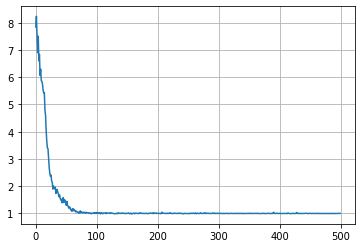

In [76]:
plt.plot(energy)
plt.grid()
plt.show()

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

N = 1000000
x, accepted = system.Sampler(N)
print(x.shape)
print(f"{accepted}/{20*N}")

(1000000, 2)
11887920/20000000


In [78]:
bins = np.linspace(0, 3, 100)
density = oneBodyDensity(x, bins, mode = "radial2D")/N
density_analytical = 1/np.pi*np.exp(-bins**2)

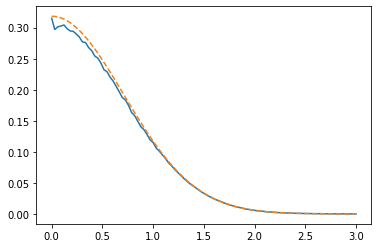

In [79]:
plt.plot(bins, density)
plt.plot(bins, density_analytical, "--")
plt.show()

## 3D

#### Model Parameters

In [80]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes)
external = HarmonicOsc(1)
sampler = Metropolis(1, 20)

system = System(num_part = 1,
                 dim = 3,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)

#### Training

In [81]:
num_epochs = 500
batch_size = 500

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 11.20739719256565
epoch: 100, Energy: 1.5203512391568046
epoch: 200, Energy: 1.5221706091990896
epoch: 300, Energy: 1.5083389862439984
epoch: 400, Energy: 1.4999072354628369



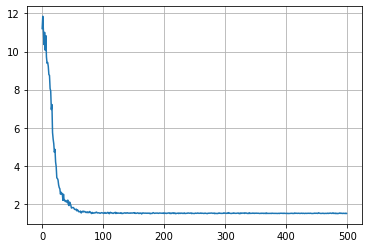

In [82]:
plt.plot(energy)
plt.grid()
plt.show()

In [83]:
tf.random.set_seed(42)
np.random.seed(42)

N = 1000000
x, accepted = system.Sampler(N)
print(x.shape)
print(f"{accepted}/{20*N}")

(1000000, 3)
10247734/20000000


In [84]:
bins = np.linspace(0, 3, 100)
density = oneBodyDensity(x, bins, mode = "radial3D")/N

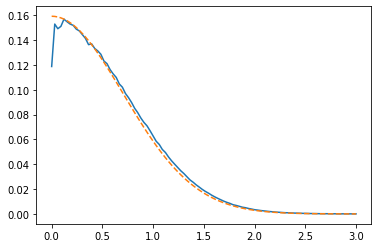

In [86]:
plt.plot(bins, density)
plt.plot(bins, 1/(2 * np.pi)*np.exp(-bins**2), "--")
plt.show()